<a href="https://colab.research.google.com/github/VA0211/DAT301m_Group9/blob/main/VinDr_PR_F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vinmammo-75-fullsize:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4529794%2F7748475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T073900Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D914da07f3f121fb59e500f73037b81d88f802a1dc63a2d8dc978b7483f61b2cabc403a3a3f99751536cbb5d94614eb1c0fa6c8b5658f7732030896fcf79b86176de931ee7b6587e77c7479a4b0f383cd0a884782db06ea895c5eb2f208b9fd3302e5f11f9369ef83e034fbb056a29c509c1a8908314fe91e5f75353777d4174c26f629b2200706913359247a3bd4fec0313c825d4d9b00d691eef60cc9b3ad8cb27f8c68632ce38fdf6f7301932d28f48f468d83f539a7ae1f5413d5215fc3ff61dcde2ad1f1ca85eb4262890079168451446edd5ee9d9509b561e4e80913b52fe077c5e54f4f6cb893e8a4f0b2d11bfdff4460b436178213bcb62d30adde935'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15184660767 bytes downloaded
Downloaded and uncompressed: vinmammo-75-fullsize
Data source import complete.


In [2]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [3]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Check if GPU is used by TensorFlow
print("GPU in use: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
TensorFlow Version:  2.15.0
GPU in use:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **Read Data**

In [6]:
df = pd.read_csv("/kaggle/input/vinmammo-75-fullsize/full_df.csv")
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
...,...,...,...,...,...,...,...,...,...,...
15999,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test
16000,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test
16001,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test
16002,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test


In [7]:
df['image_path'] = '/kaggle/input/vinmammo-75-fullsize/png/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0',
                                       'BI-RADS 2': '0',
                                       'BI-RADS 3': '1',
                                       'BI-RADS 4': '1',
                                       'BI-RADS 5': '1'})
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,image_path,label
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/9ba...,0
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c56...,0
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/68b...,0
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/968...,0
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c48...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15999,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/5e9...,0
16000,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0
16001,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0
16002,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0


In [8]:
train_df = df[df['split'] == 'training']
tmp_test_df = df[df['split'] == 'test']

test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

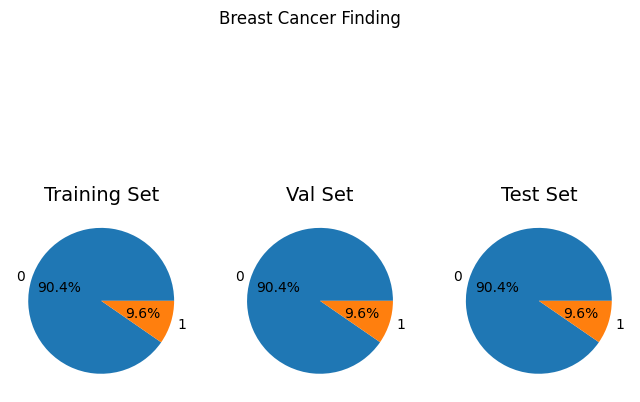

In [9]:
# label distributions
import matplotlib.pyplot as plt
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# label distributions
value_1 = val_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Val Set', fontsize=14)

# label distributions
value_2 = test_df['label'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Test Set', fontsize=14)

plt.show()

In [10]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors.
    '''

    color = 'rgb'
    img_size = (224, 224)
    img_shape = (224, 224, 3)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(horizontal_flip= True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'image_path', y_col= 'label', target_size=img_size, class_mode= 'categorical',
                                          color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [11]:
# create function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#### **Visualize Dataset**

In [12]:
batch_size = 16
train_gen, valid_gen, test_gen = create_gens(train_df, val_df, test_df, batch_size)

Found 12004 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights

array([0.55328171, 5.19204152])

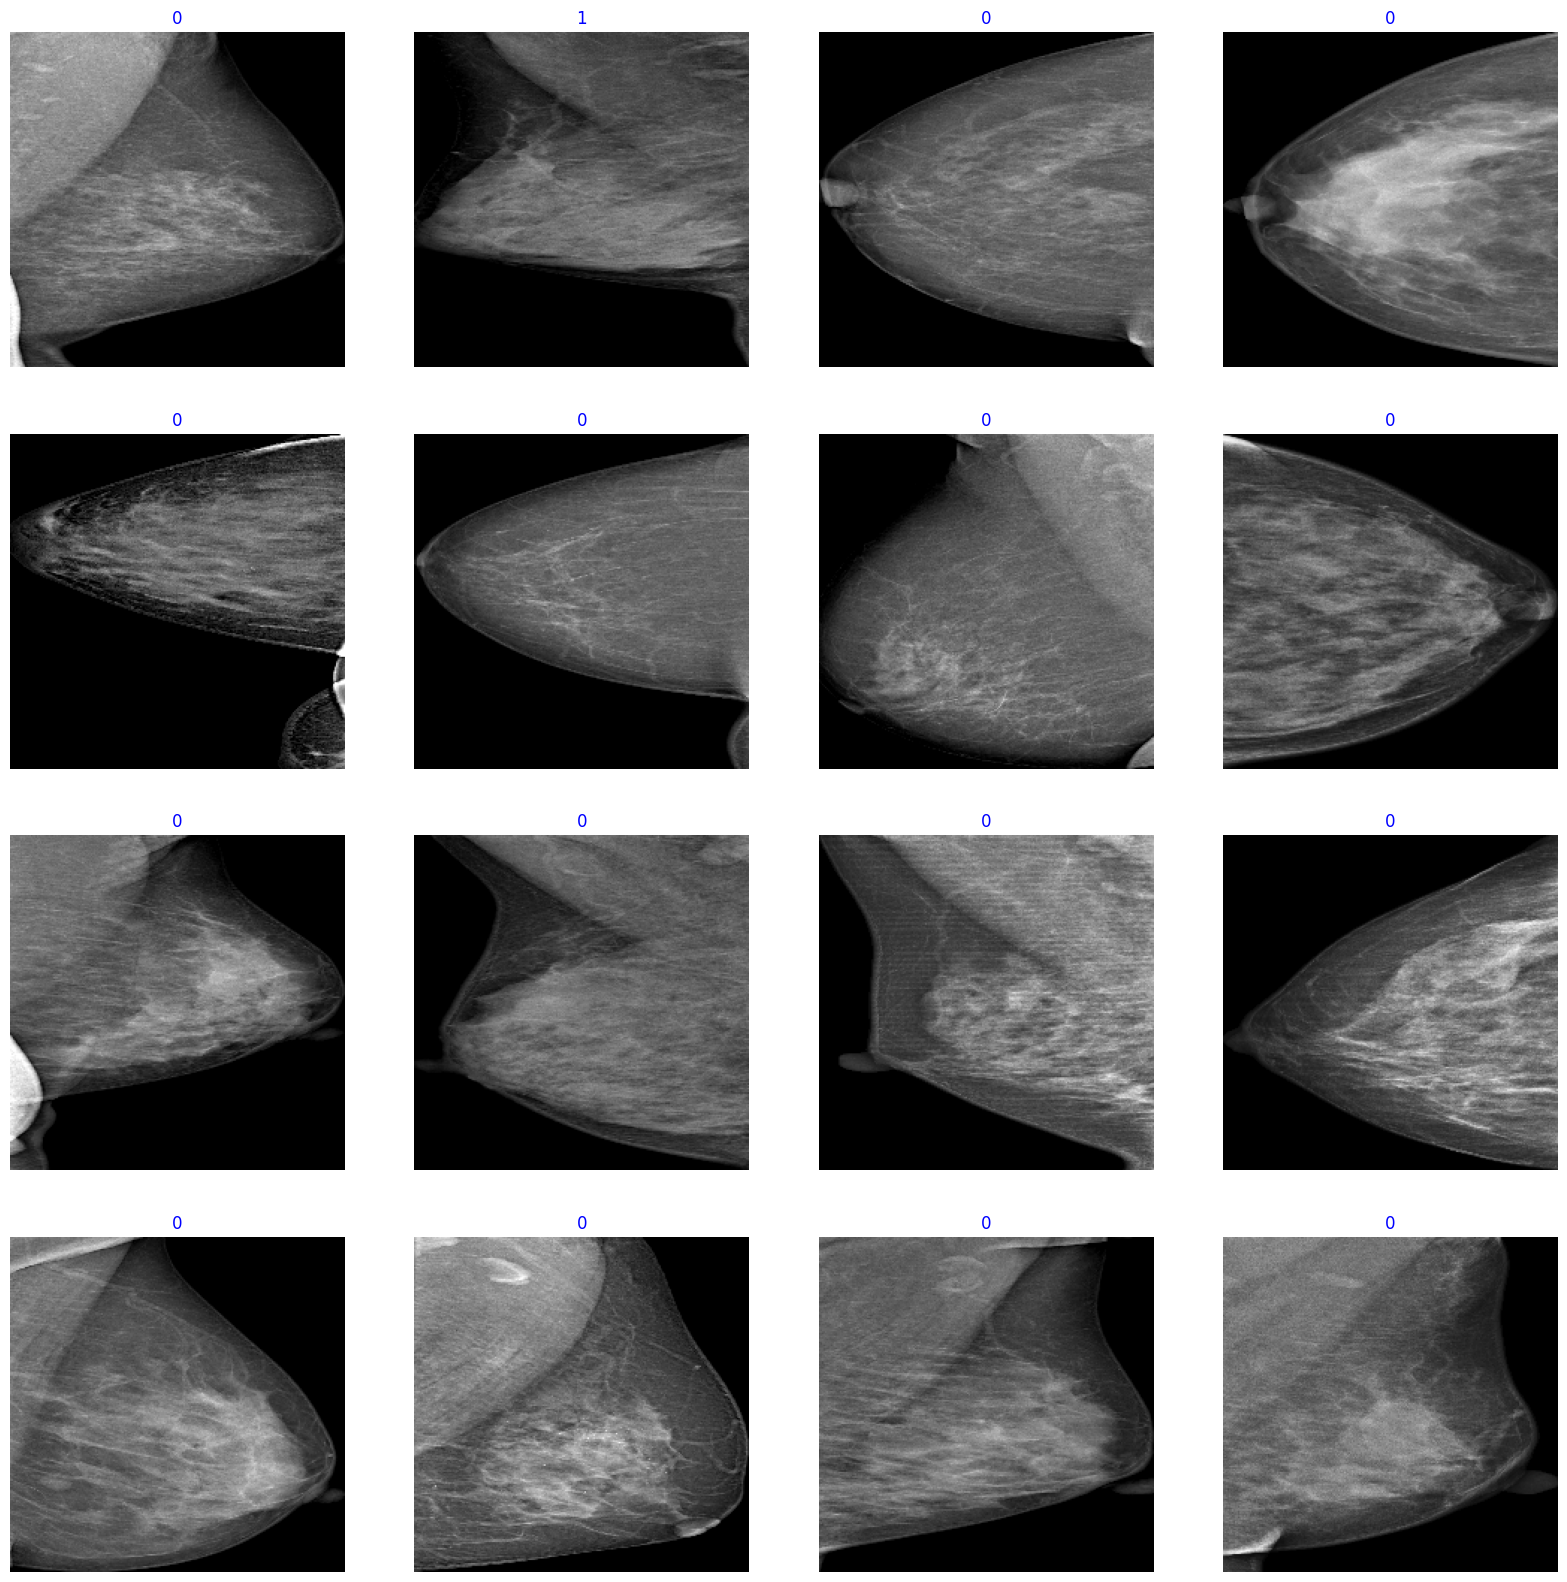

In [14]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

### **Model and metrics**

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.callbacks import Callback

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)

        true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred))
        false_positives = tf.reduce_sum(tf.clip_by_value(y_pred - y_true, 0, 1))
        false_negatives = tf.reduce_sum(tf.clip_by_value(y_true - y_pred, 0, 1))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


# class PrecisionRecallCurve(tf.keras.metrics.Metric):
#     def __init__(self, threshold=0.5, name='precision_recall_curve', **kwargs):
#         super(PrecisionRecallCurve, self).__init__(name=name, **kwargs)
#         self.threshold = threshold
#         self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
#         self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
#         self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')
#         self.precision_values = []
#         self.recall_values = []

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)

#         true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred))
#         false_positives = tf.reduce_sum(tf.clip_by_value(y_pred - y_true, 0, 1))
#         false_negatives = tf.reduce_sum(tf.clip_by_value(y_true - y_pred, 0, 1))

#         self.true_positives.assign_add(true_positives)
#         self.false_positives.assign_add(false_positives)
#         self.false_negatives.assign_add(false_negatives)

#         precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
#         recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

#         self.precision_values.append(precision)
#         self.recall_values.append(recall)

#     def result(self):
#         return sum(self.precision_values)/len(self.precision_values), sum(self.recall_values)/len(self.recall_values)

#     def reset_state(self):
#         self.true_positives.assign(0)
#         self.false_positives.assign(0)
#         self.false_negatives.assign(0)

class PrecisionRecallCurve(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='precision_recall_curve', **kwargs):
        super(PrecisionRecallCurve, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)

        true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred))
        false_positives = tf.reduce_sum(tf.clip_by_value(y_pred - y_true, 0, 1))
        false_negatives = tf.reduce_sum(tf.clip_by_value(y_true - y_pred, 0, 1))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

        return tf.reduce_mean(precision), tf.reduce_mean(recall)

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

class PrecisionRecallCurveCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, gen):
        super(PrecisionRecallCurveCallback, self).__init__()
        self.model = model
        self.gen = gen
        self.precision_values = []
        self.recall_values = []

    def on_epoch_end(self, epoch, logs=None):

        y_pred_test = self.model.predict(self.gen)
        precision_test, recall_test, _ = precision_recall_curve(self.gen.labels, y_pred_test)
        pr_auc_test = auc(recall_test, precision_test)
        logs['pr_auc'] = pr_auc_test
        self.precision_values.append(precision_test)
        self.recall_values.append(recall_test)

    def result(self):
        return np.array(self.precision_values), np.array(self.recall_values)

    def plot_pr_curve(self):
        plt.figure(figsize=(8, 8))

        for precision, recall in zip(self.precision_values, self.recall_values):
            plt.plot(recall, precision, label='PR Curve')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

In [28]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,
                                                               weights="imagenet",
                                                               input_shape=img_shape, pooling='max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(512, kernel_regularizer=regularizers.l2(l= 0.016),
               activity_regularizer=regularizers.l1(0.006),
               bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed= 123),
    Dense(class_count, activation= 'softmax')])

model.compile(Adamax(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics= ['accuracy',F1Score(),PrecisionRecallCurve()])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 4711589 (17.97 MB)
Trainable params: 466

Personal note about the parameter in model compile:
- FocalLoss:
    + Alpha (alpha):
        * Purpose: Alpha is a weighting factor assigned to each class. It helps to balance the contribution of positive and negative samples during the computation of the loss.
        * Effect: A higher alpha gives more weight to the minority class (in your case, malignant mammograms), making the model more sensitive to the minority class. Conversely, a lower alpha reduces the emphasis on the minority class.
    + Gamma (gamma):
        * Purpose: Gamma controls the focusing parameter of the loss. It modulates how much the loss should focus on hard-to-classify examples (examples with low confidence).
        * Effect: A higher gamma increases the focusing effect, making the loss more sensitive to misclassified examples. This is particularly useful when dealing with a small number of hard-to-classify instances.
- F1Score:
    + Default Threshold (0.5):
        * Predictions with a probability greater than or equal to 0.5 are classified as the positive class (malignant in your case).
        * This threshold is a balanced point, but in imbalanced datasets, it may not prioritize the minority class effectively.
    + Lower Threshold (e.g., 0.3):
        * Predictions with a probability greater than or equal to 0.3 are classified as the positive class.
        * This lower threshold makes the model more sensitive to the malignant class, potentially increasing recall for the minority class.
- PR Curve:
    + A lower threshold increases the likelihood that the model will predict a positive (malignant) class for a broader range of predicted probabilities. This results in a higher recall at the expense of precision.

#### **Train model**

In [29]:
epochs = 5
history = model.fit(train_gen, epochs=epochs, verbose=1,
                    validation_data= valid_gen,
                    validation_steps=None, shuffle=False,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/5
751/751 [==============================] - 477s 580ms/step - loss: 8.9487 - accuracy: 0.5458 - f1_score: 0.5458 - precision_recall_curve: 0.5458 - val_loss: 6.1357 - val_accuracy: 0.7610 - val_f1_score: 0.7610 - val_precision_recall_curve: 0.7610
Epoch 2/5
751/751 [==============================] - 429s 572ms/step - loss: 4.9442 - accuracy: 0.6522 - f1_score: 0.6522 - precision_recall_curve: 0.6522 - val_loss: 3.9121 - val_accuracy: 0.8620 - val_f1_score: 0.8620 - val_precision_recall_curve: 0.8620
Epoch 3/5
751/751 [==============================] - 431s 574ms/step - loss: 3.2180 - accuracy: 0.7163 - f1_score: 0.7163 - precision_recall_curve: 0.7163 - val_loss: 2.5584 - val_accuracy: 0.8085 - val_f1_score: 0.8085 - val_precision_recall_curve: 0.8085
Epoch 4/5
751/751 [==============================] - 437s 582ms/step - loss: 2.1083 - accuracy: 0.7425 - f1_score: 0.7425 - precision_recall_curve: 0.7425 - val_loss: 1.6330 - val_accuracy: 0.8505 - val_f1_score: 0.8505 - val_pre

In [30]:
history.history

{'loss': [8.948724746704102,
  4.944187641143799,
  3.2179555892944336,
  2.108320713043213,
  1.4433891773223877],
 'accuracy': [0.5458180904388428,
  0.6521992683410645,
  0.7162612676620483,
  0.7425025105476379,
  0.7694101929664612],
 'f1_score': [0.545818030834198,
  0.6521992087364197,
  0.7162612676620483,
  0.7425025105476379,
  0.7694100737571716],
 'precision_recall_curve': [array([0.5458181, 0.5458181], dtype=float32),
  array([0.65219927, 0.65219927], dtype=float32),
  array([0.71626127, 0.71626127], dtype=float32),
  array([0.7425025, 0.7425025], dtype=float32),
  array([0.7694102, 0.7694102], dtype=float32)],
 'val_loss': [6.1356520652771,
  3.9120638370513916,
  2.5584042072296143,
  1.6329691410064697,
  1.3202848434448242],
 'val_accuracy': [0.7609999775886536,
  0.8619999885559082,
  0.8084999918937683,
  0.8504999876022339,
  0.6970000267028809],
 'val_f1_score': [0.7609999775886536,
  0.8619999289512634,
  0.8084999322891235,
  0.8504999279975891,
  0.6969999670982

In [31]:
# model.save('/kaggle/working/model', save_format='h5', custom_objects={'F1Score': F1Score, 'PrecisionRecallCurve':PrecisionRecallCurve})
model.save_weights('/kaggle/working/model_weights.h5')
val_df.to_csv('/kaggle/working/val_df.csv')
test_df.to_csv('/kaggle/working/test_df.csv')

#### **Display model performance**

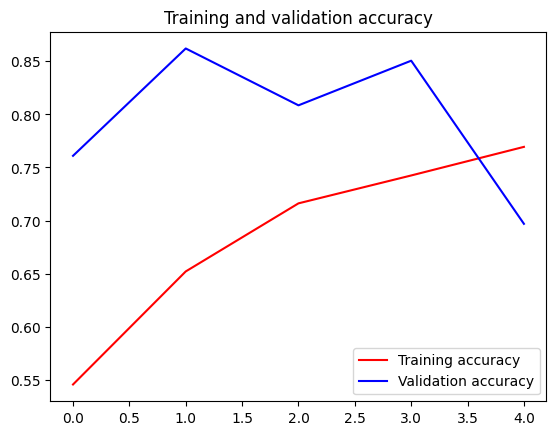

<Figure size 640x480 with 0 Axes>

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

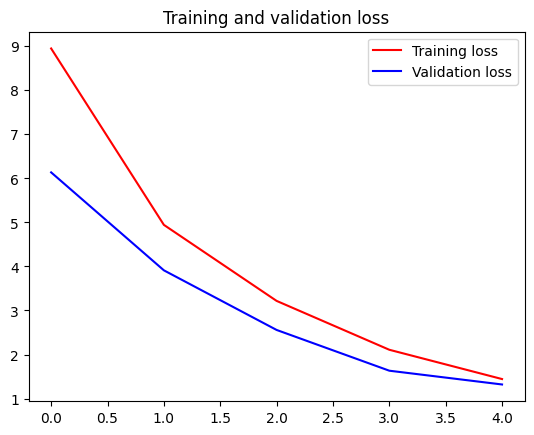

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

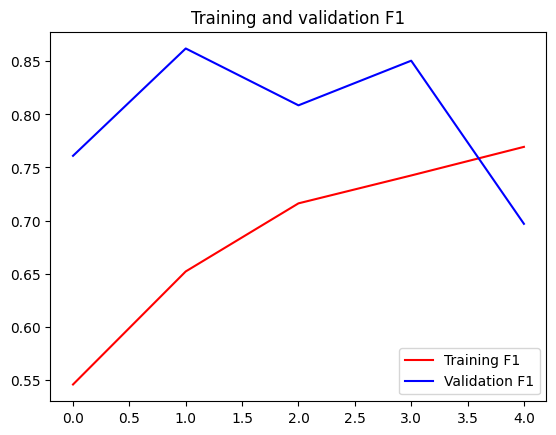

<Figure size 640x480 with 0 Axes>

In [34]:
plt.plot(epochs, f1, 'r', label='Training F1')
plt.plot(epochs, val_f1, 'b', label='Validation F1')
plt.title('Training and validation F1')
plt.legend(loc=0)
plt.figure()

plt.show()

#### **Evaluate model**

In [39]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1 Score: ", train_score[2])
print("Train PR Curve: ", train_score[3])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1 Score: ", valid_score[2])
print("Validation PR Curve: ", valid_score[3])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1 Score: ", test_score[2])
print("Test PR Curve: ", test_score[3])

25/25 [==============================] - 48s 2s/step - loss: 1.3100 - accuracy: 0.7040 - f1_score: 0.7040 - precision_recall_curve: 0.7040
Train Loss:  1.2695478200912476
Train Accuracy:  0.7200000286102295
Train F1 Score:  0.7199999094009399
Train PR Curve:  [0.72 0.72]
--------------------
Validation Loss:  1.2952102422714233
Validation Accuracy:  0.7149999737739563
Validation F1 Score:  0.7149999737739563
Validation PR Curve:  [0.715 0.715]
--------------------
Test Loss:  1.3100240230560303
Test Accuracy:  0.7039999961853027
Test F1 Score:  0.703999936580658
Test PR Curve:  [0.704 0.704]


### **Get Predictions**

In [40]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

25/25 [==============================] - 49s 2s/step
[1 0 1 ... 0 0 1]


#### **Confusion Matrics and Classification Report**

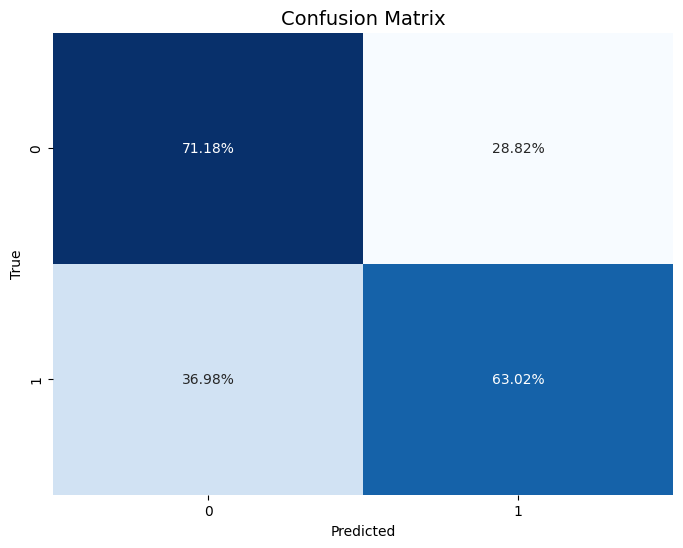

              precision    recall  f1-score   support

           0       0.95      0.71      0.81      1808
           1       0.19      0.63      0.29       192

    accuracy                           0.70      2000
   macro avg       0.57      0.67      0.55      2000
weighted avg       0.87      0.70      0.76      2000



In [41]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm=cm, labels=classes, title='Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

#### **PR Curve**

In [ ]:
# Create a PrecisionRecallCurve instance
pr_curve_visualize = PrecisionRecallCurve()

# Iterate over the test generator and update the PR curve
for batch in test_gen:
    x_test_batch, y_true_batch = batch  # Adjust based on your generator structure
    y_pred_batch = model.predict(x_test_batch)

    # Update the state with true labels and predicted probabilities
    pr_curve_visualize.update_state(y_true_batch, y_pred_batch)

# Get precision and recall values
precision, recall = pr_curve_visualize.result()

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# Get precision and recall values
precision, recall = pr_curve_visualize.result()

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_recall_curve

# # Assuming test_gen yields (X_test, y_test)
# X_test, y_test = zip(*test_gen)

# # Convert the list of arrays to a single numpy array
# X_test = np.vstack(X_test)
# y_test = np.vstack(y_test)

# # Make predictions
# y_pred = model.predict(X_test)

# precision, recall, thresholds = precision_recall_curve(y_test[:, 1], y_pred[:, 1])

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.show()
